In [1]:
from operator import eq
import pandas as pd
import pandas_ta as ta
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf

## IMPORT SKLEARN
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix

import numpy as np

# IMPORT TENSORFLOW AND KERAS
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
#from tensorflow.keras.optimizers import Adam, RMSprop 
#from tensorflow.keras.utils import plot_model
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame()

In [2]:
equityData = pd.read_excel('StockDataCSV/EquityDataExcel.xlsx', sheet_name='Sheet1', index_col=0, usecols=[0,1,2,3,4,5,6,7], engine='openpyxl')
equityData.dropna(inplace=True)
equityData.columns = ['BTCUSD', 'BrentCrude', 'DollarIDX', 'Gold', 'UST5Y', 'SNP500', 'UST10Y']
equityData.drop(index=equityData.index[0], axis=0, inplace=True)
equityData.head()

,BTCUSD,BrentCrude,DollarIDX,Gold,UST5Y,SNP500,UST10Y
2017-07-31 00:00:00,2875.34,50.17,92.86,1266.6,1.832,2470.3,2.292
2017-08-01 00:00:00,2718.26,49.16,93.03,1272.6,1.799,2476.35,2.251
2017-08-02 00:00:00,2710.67,49.59,92.83,1271.8,1.819,2477.57,2.262
2017-08-03 00:00:00,2804.73,49.03,92.81,1267.8,1.79,2472.16,2.228
2017-08-04 00:00:00,2895.89,49.58,93.54,1258.3,1.822,2476.83,2.267


In [3]:
myStrategy = ta.Strategy(
name='Blokkere CryptoBot 201',
ta=[
    {"kind": "sma", "length": 50},
    {"kind": "sma", "length": 200},
    {"kind": "bbands", "length": 20},
    {"kind": "rsi"},
    {"kind": "macd", "fast": 8, "slow": 21},
    {"kind": "fwma"},
])

In [4]:
names =['BTCUSD','Crude','DXY','Gold','UST5Y','SnP500','UST10Y']
diffStr = {}
for i in range(0,7):
    diffStr[i] = pd.read_excel('StockDataCSV/EquityDataExcel.xlsx', sheet_name='Sheet1', index_col=0, usecols=[0,i+1,i+8,i+15,i+22,i+29,i+36], engine='openpyxl')
    diffStr[i].dropna(inplace=True)
    diffStr[i].columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    diffStr[i].drop(index=diffStr[i].index[0], axis=0, inplace=True)

In [5]:
for i in range(0,7):
    diffStr[i].ta.strategy(myStrategy)
    diffStr[i].drop(diffStr[i].columns[[0, 1, 2,3,4,5]], axis=1, inplace=True)
    
    for j in range(0,len(diffStr[i].columns)):
        diffStr[i].rename(columns= { diffStr[i].columns[j] :  (diffStr[i].columns[j] + '_'+names[i])},inplace=True)
        

In [6]:
btcdata = pd.read_excel('StockDataCSV/EquityDataExcel.xlsx', sheet_name='Sheet1', index_col=0, usecols=[0,1], engine='openpyxl')
btcdata.drop(index=btcdata.index[0], axis=0, inplace=True)
btcdata = btcdata.diff(-1)

In [43]:
#, diffStr[1], diffStr[2],diffStr[3],diffStr[4],diffStr[5],diffStr[6] 
frames = [btcdata, diffStr[0]]
res = pd.concat(frames,axis=1)

res

,Adj Close,SMA_50_DXY,SMA_200_DXY,BBL_20_2.0_DXY,BBM_20_2.0_DXY,BBU_20_2.0_DXY,BBB_20_2.0_DXY,BBP_20_2.0_DXY,RSI_14_DXY,MACD_8_21_9_DXY,MACDh_8_21_9_DXY,MACDs_8_21_9_DXY,FWMA_10_DXY
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31 00:00:00,157.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 00:00:00,7.59009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-02 00:00:00,-94.0601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-03 00:00:00,-91.1599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-26 00:00:00,-1690.79,104.693401,99.19530,104.717551,106.848001,108.978451,3.987815,0.580265,58.170496,0.445278,-0.303037,0.748314,106.934968
2022-07-27 00:00:00,-913.338,104.746201,99.25715,104.927939,106.915001,108.902062,3.717087,0.382992,51.531222,0.330926,-0.333911,0.664837,106.747133
2022-07-28 00:00:00,39.2539,104.818801,99.31910,105.267515,106.998000,108.728486,3.234613,0.312769,50.689289,0.230255,-0.347666,0.577920,106.588811
2022-07-29 00:00:00,148.426,104.873801,99.37890,105.442422,107.036000,108.629579,2.977649,0.14357,46.970252,0.095331,-0.386072,0.481402,106.319930


In [44]:
res.dropna(inplace=True)
res
#res.to_excel('StockDataCSV/CleanedDataRES_withBTC.xlsx')

,Adj Close,SMA_50_DXY,SMA_200_DXY,BBL_20_2.0_DXY,BBM_20_2.0_DXY,BBU_20_2.0_DXY,BBB_20_2.0_DXY,BBP_20_2.0_DXY,RSI_14_DXY,MACD_8_21_9_DXY,MACDh_8_21_9_DXY,MACDs_8_21_9_DXY,FWMA_10_DXY
2018-05-15,141.55,90.661400,91.99925,89.751886,91.877500,94.003114,4.627061,0.815791,72.353022,0.735378,-0.020543,0.755921,92.875385
2018-05-16,274.51,90.736800,92.00190,90.112957,92.066000,94.019043,4.242703,0.838958,73.675970,0.758725,0.002244,0.756482,93.073986
2018-05-17,-156.65,90.813400,92.00410,90.459233,92.242500,94.025767,3.866475,0.844172,74.299248,0.770411,0.011143,0.759268,93.228322
2018-05-18,3.79004,90.883800,92.00815,90.758889,92.408500,94.058111,3.570257,0.87327,75.620203,0.785433,0.020932,0.764501,93.388462
2018-05-21,377.21,90.955600,92.01250,90.952332,92.545500,94.138668,3.442995,0.856052,75.933649,0.785440,0.016751,0.768689,93.502727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,121.947,104.616801,99.13195,104.360950,106.714001,109.067052,4.410013,0.450278,52.746458,0.456852,-0.367221,0.824073,106.782870
2022-07-26,-1690.79,104.693401,99.19530,104.717551,106.848001,108.978451,3.987815,0.580265,58.170496,0.445278,-0.303037,0.748314,106.934968
2022-07-27,-913.338,104.746201,99.25715,104.927939,106.915001,108.902062,3.717087,0.382992,51.531222,0.330926,-0.333911,0.664837,106.747133
2022-07-28,39.2539,104.818801,99.31910,105.267515,106.998000,108.728486,3.234613,0.312769,50.689289,0.230255,-0.347666,0.577920,106.588811


In [45]:
ModelY = np.where(res['Adj Close'] < 0, 0, 1)
ModelY = np.delete(ModelY, (0), axis=0)
ModelY = np.append(ModelY, [0], axis=0)


ModelX = res.drop('Adj Close', axis=1)

In [46]:
# Split Data
ModelX_train, ModelX_test, Modely_train, Modely_test = train_test_split(ModelX, ModelY, test_size=0.3, shuffle=False)

# Linear Regression
reg = LogisticRegression(random_state=0).fit(ModelX_train, Modely_train)
reg.score(ModelX_train,Modely_train)

0.5309139784946236

In [47]:
reg.score(ModelX_test, Modely_test)

0.4890282131661442

In [48]:
#### DECISION TREE
clf_type1 = tree.DecisionTreeClassifier(
    min_samples_split = 150,
    max_depth = 6,
    min_samples_leaf = 10,
    criterion='gini'
    )
 
clf_type1 = clf_type1.fit(ModelX_train, Modely_train)


print(f'Train Accuracy: {clf_type1.score(ModelX_train, Modely_train):0.4}')
print(f'Test Accuracy: {clf_type1.score(ModelX_test,Modely_test):0.4}')

Train Accuracy: 0.6438
Test Accuracy: 0.4734


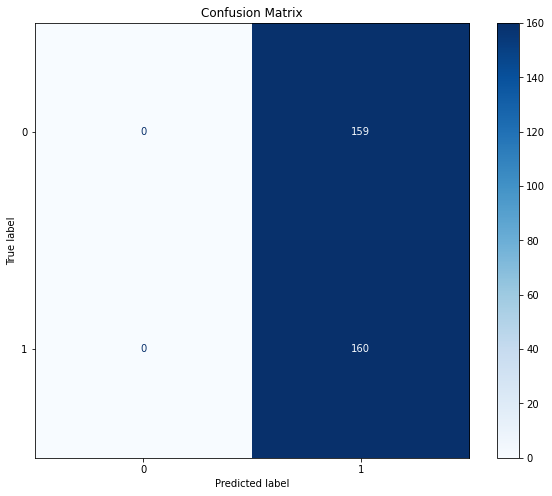

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(clf_type1, ModelX_test, Modely_test, ax=ax, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [20]:
# Hyper parameter optimization
param_grid = {'criterion': ['gini','entropy','log_loss'],
              'max_depth': [2,3,4,5,6],
              'min_samples_leaf': [5,10,20,30,50,75],
              'min_samples_split': [25,50,100,150]}

# perform Grid search
gs = GridSearchCV(clf_type1, param_grid)
gs.fit(ModelX_train, Modely_train)

# best parameters
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 30,
 'min_samples_split': 150}

In [21]:
gs.best_score_

0.49802285506983496

In [31]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)


# perform random search
rs = RandomizedSearchCV(clf_type1, param_grid, n_iter=500, scoring='f1', cv=tscv)
rs.fit(ModelX_train, Modely_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=4,
                                                    min_samples_leaf=30,
                                                    min_samples_split=150),
                   n_iter=500,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 3, 4, 5, 6],
                                        'min_samples_leaf': [5, 10, 20, 30, 50,
                                                             75],
                                        'min_samples_split': [25, 50, 100,
                                                              150]},
                   scoring='f1')

In [32]:
rs.best_params_

{'min_samples_split': 150,
 'min_samples_leaf': 10,
 'max_depth': 6,
 'criterion': 'gini'}

In [33]:
rs.best_score_

0.5027645033244752